<a href="https://colab.research.google.com/github/maysahayu/Collab-Project/blob/main/scrap_prepro_fe_cluster_Webtoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCRAPE WEB WEBTOON

In [7]:
import requests as req
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import csv
import os
hades = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}

In [12]:
def scraping_springer():
    data_list = []
    base_url = "https://www.webtoons.com/id/"
    headers = {'User-Agent': 'Mozilla/5.0'}
    genres = ["drama", "fantasy", "romantic_fantasy", "comedy", "action", "slice_of_life", "romance", "thriller", "horror", "local"]

    for page in genres:
        url = f"https://www.webtoons.com/id/genres/{page}?sortOrder=READ_COUNT"

        try:
            halaman_utama = req.get(url, headers=headers).text
            soup = bs(halaman_utama, 'lxml')

            comics = soup.select('ul.card_lst a.card_item')

            if not comics:
                print(f"Tidak ada artikel ditemukan di halaman {page}.")
                continue

            for comic in comics:
                judul_element = comic.find('p', class_='subj')
                judul = judul_element.text.strip() if judul_element else 'Judul tidak ditemukan'

                author_element = comic.find('p', class_='author')
                author = author_element.text.strip() if author_element else 'Author tidak ditemukan'

                # URL halaman detail komik
                detail_url = comic['href']

                # Masuk ke halaman detail untuk mengambil ringkasan
                try:
                    detail_page = req.get(detail_url, headers=headers).text
                    detail_soup = bs(detail_page, 'lxml')

                    # Cari elemen ringkasan di halaman detail
                    desc_element = detail_soup.find('p', class_='summary')
                    desc = desc_element.text.strip() if desc_element else 'Ringkasan tidak ditemukan'

                except Exception as e:
                    print(f"Terjadi kesalahan saat mengakses {detail_url}: {e}")
                    desc = 'Ringkasan tidak ditemukan'  # Menangani jika halaman detail gagal diakses

                # Menambahkan data komik yang berhasil di-scrape
                data_list.append([judul, author, desc])

        except Exception as e:
            print(f"Terjadi kesalahan saat mengakses {url}: {e}")

    # Menampilkan hasil scraping dalam bentuk DataFrame
    df = pd.DataFrame(data_list, columns=['Judul Komik', 'Author', 'Ringkasan'])
    print(df)

    # Menyimpan DataFrame ke dalam file CSV
    df.to_csv('data_webtoon.csv', index=False, encoding='utf-8')

    print("Data berhasil disimpan")

    return df


In [14]:
df_train = scraping_springer()
df_train

                     Judul Komik                       Author  \
0                        LOOKISM                 Taejoon Park   
1                The Real Lesson    CHAE YONGTAEK / HAN GARAM   
2     Undercover at Chaebol High                           AJ   
3               GOOD/BAD FORTUNE                 Ariel Duyung   
4                       QUESTISM  PTJ cartoon company Academy   
...                          ...                          ...   
1501      SCRAMBLED: Journeylism                  Lintankleen   
1502                Dracko Diary                     Indra AD   
1503                Perhaps Mine           Cikakey / Candrasa   
1504                 Summer Rain                    kiyoshin_   
1505                  Oh My Boy!                       Kanipa   

                                              Ringkasan  
0        Cowok ini punya 2 wujud! Pilih yang mana ya..?  
1     Setelah undang-undang larangan memukul para si...  
2     Lee Dakyung, anggota sebuh organisasi g

,Judul Komik,Author,Ringkasan
0,LOOKISM,Taejoon Park,Cowok ini punya 2 wujud! Pilih yang mana ya..?
1,The Real Lesson,CHAE YONGTAEK / HAN GARAM,Setelah undang-undang larangan memukul para si...
2,Undercover at Chaebol High,AJ,"Lee Dakyung, anggota sebuh organisasi gelap, t..."
3,GOOD/BAD FORTUNE,Ariel Duyung,"Hati-hati! Jika bertemu mereka, nasib kalian a..."
4,QUESTISM,PTJ cartoon company Academy,Kim Soohyun selalu merasa lemah dan tak bisa m...
...,...,...,...
1501,SCRAMBLED: Journeylism,Lintankleen,Visi adalah seorang siswi SMA yang pemalu. Saa...
1502,Dracko Diary,Indra AD,Dracko kini pergi merantau demi mengejar cita-...
1503,Perhaps Mine,Cikakey / Candrasa,Mine yang baru saja dipecat karena suatu insid...
1504,Summer Rain,kiyoshin_,Banyak hal aneh terjadi saat hujan panas. Sala...


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Judul Komik  1506 non-null   object
 1   Author       1506 non-null   object
 2   Ringkasan    1506 non-null   object
dtypes: object(3)
memory usage: 35.4+ KB


# PRE-PROCESSING

In [22]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.6 MB/s eta 0:00:00


In [23]:
import pandas as pd
import string
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

# File paths
file_path = "data_webtoon.csv"
output_path = "prepro_webtoon.csv"
kamus_alay = "colloquial-indonesian-lexicon.csv"

kolom_target = 'Ringkasan'  # Kolom target yang akan diproses

# Mendapatkan daftar stopwords
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghilangkan tanda baca
def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

# Fungsi untuk menghilangkan URL dari teks
def remove_url(text):
    if isinstance(text, str):
        url_pattern = r'http\S+|www\S+'
        return re.sub(url_pattern, '', text)
    return text

# Fungsi untuk menghilangkan HTML tags dari teks
def remove_html_tags(text):
    if isinstance(text, str):
        return re.sub(r'<.*?>', '', text)  # Menghapus semua yang ada di antara <>
    return text

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        words = re.findall(r'\b\w+\b', text)  # Mengambil kata-kata yang valid
        return ' '.join([word for word in words if word not in stop_words])
    return text

def remove_digits(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)  # Menghapus semua digit
    return text

# Fungsi untuk mengonversi emoji menjadi teks deskripsi sederhana
def convert_emoji_to_text(text):
    if isinstance(text, str):
        return emoji.demojize(text)  # Mengonversi emoji menjadi teks
    return text

# Fungsi untuk menghilangkan simbol yang tidak diinginkan
def remove_special_characters(text):
    if isinstance(text, str):
        return text.replace("ð", "").replace("â", "").replace("º", "").replace("ï", "")
    return text

# Membaca file Kamus Alay dan membuat dictionary alay -> formal
df_slang = pd.read_csv(kamus_alay)
alay_dict = dict(zip(df_slang['slang'], df_slang['formal']))

# Fungsi untuk mengganti kata alay dengan kata formal
def normalize_alay(text):
    if isinstance(text, str):
        return ' '.join([alay_dict.get(word, word) for word in text.split()])
    return text

# Membaca file CSV
data = pd.read_csv(file_path)

# Mengubah teks menjadi lowercase pada kolom target
data[kolom_target] = data[kolom_target].str.lower()

# Menghapus URL terlebih dahulu
data[kolom_target] = data[kolom_target].apply(remove_url)

# Menghapus HTML tags setelah URL dihilangkan
data[kolom_target] = data[kolom_target].apply(remove_html_tags)

# Menghapus tanda baca setelah URL dihilangkan
data[kolom_target] = data[kolom_target].apply(remove_punctuation)

# Mengonversi emoji menjadi deskripsi teks sederhana
data[kolom_target] = data[kolom_target].apply(convert_emoji_to_text)

# Menghilangkan simbol yang tidak diinginkan dari teks
data[kolom_target] = data[kolom_target].apply(remove_special_characters)

# Menghapus digit angka
data[kolom_target] = data[kolom_target].apply(remove_digits)

# Menghapus stopwords
data[kolom_target] = data[kolom_target].apply(remove_stopwords)

# Mengganti kata-kata alay dengan kata formal
data[kolom_target] = data[kolom_target].apply(normalize_alay)

# Menyimpan hasilnya kembali ke file CSV
data.to_csv(output_path, index=False)

print(f"Semua teks telah diubah ke huruf kecil, URL, tanda baca, emoji telah dikonversi, stopwords, dan kata alay pada kolom '{kolom_target}' telah dihapus/diganti, dan file disimpan sebagai '{output_path}'")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Semua teks telah diubah ke huruf kecil, URL, tanda baca, emoji telah dikonversi, stopwords, dan kata alay pada kolom 'Ringkasan' telah dihapus/diganti, dan file disimpan sebagai 'prepro_webtoon.csv'


In [97]:
df = df[['Ringkasan']]

# Exploratory Data Analysis

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Judul Komik  1506 non-null   object
 1   Author       1504 non-null   object
 2   Ringkasan    1506 non-null   object
 3   count_words  1506 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 47.2+ KB


In [99]:
data['Ringkasan'].value_counts()

,count
Ringkasan,
rion berpikir hidupnya kedatangan siswi bell menghancurkan tatapan mata bell mengendalikan bunuh bertekad membalaskan dendamnya rion,4
aru bersuara insiden bantuan teman kecilnya kiran temanteman aru berusaha menjalani kehidupan sekolah berkomunikasi berbeda,4
frana sih cewek tomboy memutuskan merubah cewek feminin disaat berubah orangorang menerima perubahannya frana memutuskan merantau pulau berharap menjalani hidup indah kehidupan frana sesuai ekspektasinya,4
sama nana kesulitan berteman bertemu kawankawan barunya sekolah harihari nana sepi diisi kisah persahabatan manis rumit,4
kisah gadis desa bernama sarmi rahayu ning tyas hayu antusias mengubah hidupnya gitugitu nekat kota kuliah berharap membesarkan usaha ibunya pembuat jamu tradisional disangka bertemu rendaru ganendra ndaru teman kecilnya bertahuntahun bertemu parasnya berubah putih bersih pokoknya tipe hayu banget sayang dikelilingi orangorang mengerikan rumor miring tentangnya hayu dengannya mengemban tudingan mirinya tersemat,4
...,...
killer legendaris bernama peter tua sakitsakitan diincar matimatian tertangkap salah kelompok mengincarnya menghilang terluka parah peter wujudnya remaja kuat raga muda sehat rencana peter perubahan hidupnya masuk akal,1
perkelahian menjaga study group,1
dowan dirundung joki game meninggal kebanyakan main game hidup tibatiba muncul quest depannya questnya benarbenar nyata,1


In [100]:
count_wd = []
for word in data['Ringkasan']:
    count = len(word.split())
    count_wd.append(count)
data['count_words'] = count_wd
data

,Judul Komik,Author,Ringkasan,count_words
0,LOOKISM,Taejoon Park,cowok wujud pilih ya,4
1,The Real Lesson,CHAE YONGTAEK / HAN GARAM,undangundang larangan memukul siswa disahkan s...,14
2,Undercover at Chaebol High,AJ,lee dakyung anggota sebuh organisasi gelap ter...,43
3,GOOD/BAD FORTUNE,Ariel Duyung,hatihati bertemu nasib berubah,4
4,QUESTISM,PTJ cartoon company Academy,kim soohyun lemah melawan teman berbuat jahat ...,15
...,...,...,...,...
1501,SCRAMBLED: Journeylism,Lintankleen,visi siswi sama pemalu memutuskan mengikuti ek...,21
1502,Dracko Diary,Indra AD,dracko pergi merantau mengejar citacitanya ani...,6
1503,Perhaps Mine,Cikakey / Candrasa,mine dipecat insiden mendadak gaji pengurus ba...,11
1504,Summer Rain,kiyoshin_,aneh hujan panas salah satunya dialami kay gad...,16


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# Import the wordcloud library
from wordcloud import WordCloud

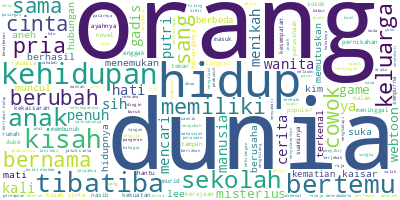

In [103]:
# Join the different processed titles together.
long_string = ','.join(list(data['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#FEATURE ENGINEERING

In [104]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [106]:
corpus = df['Ringkasan']
vectorizer = CountVectorizer(token_pattern = '(?u)\\b\\w+\\b')
X = vectorizer.fit_transform(corpus)
X

<1506x6736 sparse matrix of type '<class 'numpy.int64'>'
	with 46050 stored elements in Compressed Sparse Row format>

In [107]:
data_FE = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
data_FE

,0,00,000,1,10,100,1000,101,12,13,...,yuri,zahra,zaman,zan,zara,zener,zenus,zeron,zion,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
sum_tf = data_FE.sum(axis=0)
sum_tf[sum_tf >= 3]

,0
000,4
1,29
10,33
100,10
1000,3
...,...
yunmun,6
yura,4
yuri,5
zaman,17


In [109]:
sum_tf = data_FE.sum(axis=0)
'x' in sum_tf.index

True

In [110]:
data_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Columns: 6736 entries, 0 to zombie
dtypes: int64(6736)
memory usage: 77.4 MB


In [111]:
from nltk import word_tokenize
from tqdm import tqdm
sentences = [word_tokenize(tweet.lower()) for tweet in tqdm(df['Ringkasan'])]

100%|██████████| 1506/1506 [00:00<00:00, 2329.83it/s]


In [48]:
import gensim
model = gensim.models.Word2Vec(sentences, min_count=6, vector_size=100, window=5, workers=4)

In [112]:
model.save('word2vec.w2v')

In [113]:
model = gensim.models.Word2Vec.load('word2vec.w2v')
w2v = model.wv
w2v.index_to_key

[',',
 'yang',
 '.',
 '!',
 'dan',
 '?',
 'di',
 'dengan',
 'untuk',
 'ini',
 'dia',
 'dari',
 'seorang',
 'menjadi',
 'mereka',
 'akan',
 'itu',
 'tapi',
 'tidak',
 'bisa',
 '...',
 'ke',
 'adalah',
 'ia',
 'aku',
 'kembali',
 'namun',
 'sebagai',
 'saat',
 'oleh',
 'dalam',
 'setelah',
 'hidup',
 'orang',
 'apakah',
 'karena',
 'hari',
 'dunia',
 'tak',
 'apa',
 "''",
 'harus',
 '``',
 'ada',
 'tahun',
 'kisah',
 'cinta',
 'kehidupan',
 'ternyata',
 'masa',
 'jadi',
 'tiba-tiba',
 'semua',
 'pun',
 'bertemu',
 'ingin',
 'suatu',
 'pada',
 'sudah',
 'anak',
 'hanya',
 'sebuah',
 'membuat',
 'malah',
 'para',
 'sang',
 'pria',
 'sekolah',
 'baru',
 'satu',
 'telah',
 'lalu',
 'lain',
 'keluarga',
 'memiliki',
 'seperti',
 'lagi',
 'kini',
 'ketika',
 'tersebut',
 'berubah',
 "'",
 'si',
 'bagaimana',
 'selama',
 'selalu',
 'juga',
 'biasa',
 'bernama',
 'teman',
 'terjadi',
 'sebenarnya',
 'cowok',
 'demi',
 'sama',
 'manusia',
 'sma',
 'saja',
 'wanita',
 'lebih',
 'cerita',
 'menikah

In [114]:
w2v_set = set(w2v.index_to_key)
tfidf_set = set(sum_tf[sum_tf >= 3].index)

In [115]:
w2v_set - tfidf_set

{'!',
 '%',
 "'",
 "''",
 "'s",
 '(',
 ')',
 ',',
 '--',
 '.',
 '..',
 '...',
 '....',
 ':',
 '?',
 '``',
 'alih-alih',
 'anak-anak',
 'apa-apa',
 'benar-benar',
 'berkali-kali',
 'berpura-pura',
 'bertahun-tahun',
 'cerita-cerita',
 'diam-diam',
 'gadis-gadis',
 'gara-gara',
 'hal-hal',
 'hantu-hantu',
 'hari-hari',
 'kira-kira',
 'kisah-kisah',
 'kunang-kunang',
 'laki-laki',
 'lika-liku',
 'monster-monster',
 'murid-murid',
 'orang-orang',
 'pura-pura',
 'sakit-sakitan',
 'satu-satunya',
 'sehari-hari',
 'semena-mena',
 'teman-teman',
 'teman-temannya',
 'terus-menerus',
 'tiba-tiba',
 '‘',
 '’',
 '“',
 '”'}

In [116]:
# save dataframe of word2vec
w2v = w2v.vectors.transpose()
data_FE = pd.DataFrame(w2v)
data_FE.shape

(100, 1399)

#CLUSTERING

#KMEANS

In [117]:
from sklearn.cluster import KMeans

In [118]:
k = range(1,10)
inertia = []

for i in k:
    km_model = KMeans(n_clusters=i) # jumlah cluster akan di looping
    km_model.fit(data_FE)
    inertia.append(km_model.inertia_)

print(list(k))
print(inertia)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[3170.0927734375, 1319.7398681640625, 637.2918090820312, 374.7637023925781, 289.5497741699219, 216.80284118652344, 180.8614959716797, 116.8498306274414, 72.39784240722656]


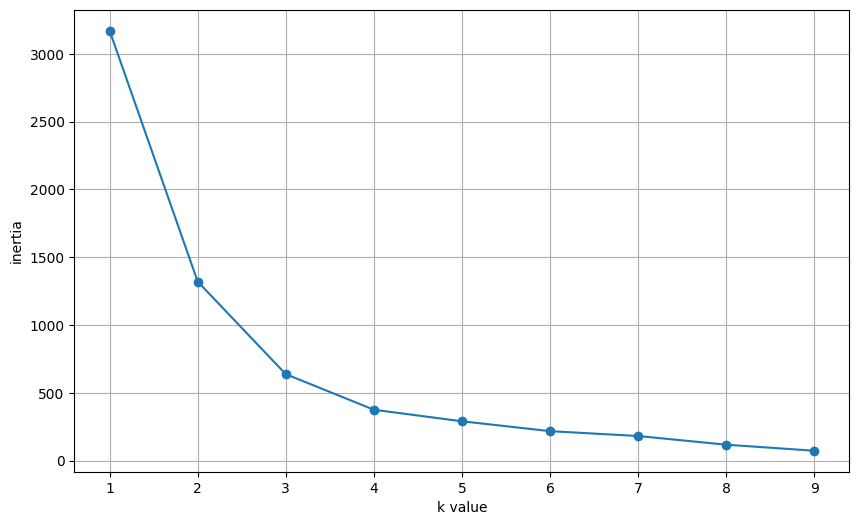

In [119]:
plt.figure(figsize=(10,6))
plt.plot(k, inertia, marker='o')
plt.xlabel('k value')
plt.ylabel('inertia')
plt.grid()
plt.show()

In [120]:
kn5 = KMeans(n_clusters=5, random_state=1).fit(data_FE)
kn5

KMeans(n_clusters=5, random_state=1)

In [121]:
kn5.labels_

array([0, 1, 2, 2, 4, 0, 4, 1, 0, 3, 3, 0, 3, 4, 4, 3, 2, 0, 3, 0, 4, 2,
       2, 0, 3, 2, 0, 3, 0, 2, 1, 3, 4, 0, 0, 1, 2, 3, 3, 0, 2, 0, 3, 3,
       4, 2, 3, 3, 2, 4, 4, 3, 2, 2, 3, 2, 4, 3, 0, 2, 3, 2, 2, 2, 0, 1,
       4, 4, 0, 1, 0, 2, 2, 3, 1, 2, 2, 2, 3, 3, 0, 2, 3, 1, 3, 2, 2, 2,
       4, 2, 4, 2, 2, 3, 1, 4, 2, 0, 2, 2], dtype=int32)

#HIERARCHICAL

In [122]:
from scipy.cluster.hierarchy import dendrogram, linkage

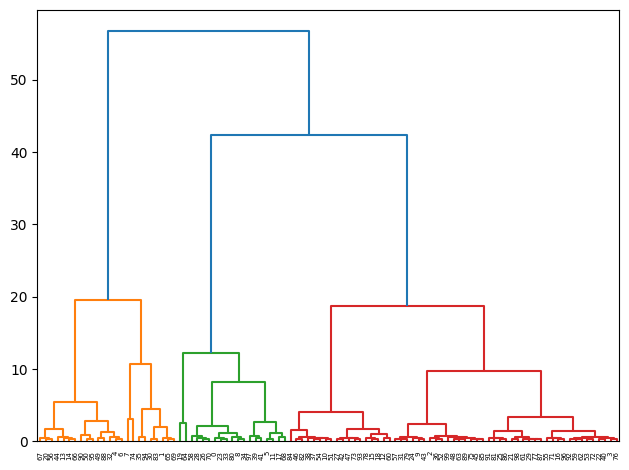

In [123]:
linkage_data = linkage(data_FE, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [124]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')
labels = hierarchical_cluster.fit(data_FE)

pred_agc = pd.Series(hierarchical_cluster.labels_)

# SILHOUETTE SCORE

In [125]:
from sklearn import metrics
labels = kn5.labels_
metrics.silhouette_score(data_FE, labels, metric='euclidean')

0.5089432

In [126]:
from sklearn import metrics
labels = pred_agc
metrics.silhouette_score(data_FE, labels, metric='euclidean')

0.49037674

# Word Cloud Hasil Setiap Cluster

## Kmeans

In [137]:
df_Kmeans = df.copy(deep=True)
df_Kmeans['cluster'] = kn5.labels_
df_Kmeans

ValueError: Length of values (100) does not match length of index (1506)

Kmeans for cluster 0


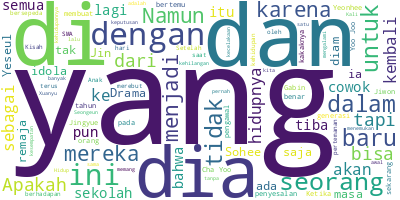

In [133]:
c=0

print('Kmeans for cluster '+str(c))
df_c = df_Kmeans[df_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(df_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 1


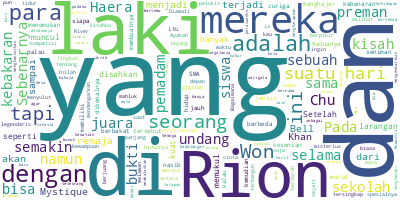

In [136]:
c=1

print('Kmeans for cluster '+str(c))
df_c = df_Kmeans[df_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(df_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [140]:
c=2

print('Kmeans for cluster '+str(c))
df_c = df_Kmeans[df_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(df_c['full_text_clean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 2


KeyError: 'cluster'

Kmeans for cluster 3


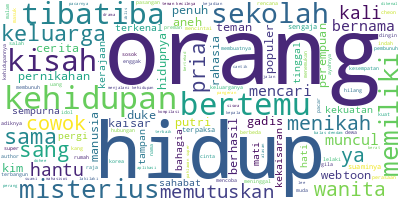

In [ ]:
c=3

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 4


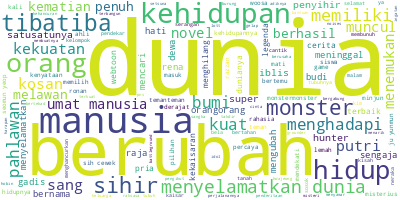

In [ ]:
c=4

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
data_agg = data.copy(deep=True)
data_agg['cluster'] = kn5.labels_
data_agg

,Judul Komik,Author,Ringkasan,count_words,cluster
0,LOOKISM,Taejoon Park,cowok wujud pilih ya,4,3
1,Girl's World,morangg,bebek angsa we will surive,5,3
2,The Real Lesson,CHAE YONGTAEK / HAN GARAM,undangundang larangan memukul siswa disahkan s...,14,3
3,Undercover at Chaebol High,AJ,lee dakyung anggota sebuh organisasi gelap ter...,43,2
4,GOOD/BAD FORTUNE,Ariel Duyung,hatihati bertemu nasib berubah,4,2
...,...,...,...,...,...
1499,SCRAMBLED: Journeylism,Lintankleen,visi siswi sama pemalu memutuskan mengikuti ek...,21,2
1500,Dracko Diary,Indra AD,dracko pergi merantau mengejar citacitanya ani...,6,3
1501,Perhaps Mine,Cikakey / Candrasa,mine dipecat insiden mendadak gaji pengurus ba...,11,1
1502,Summer Rain,kiyoshin_,aneh hujan panas salah satunya dialami kay gad...,16,0
